In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

matplotlib.rcParams['figure.facecolor'] = 'w'

In [31]:
from scgan.loader.beautygan_loader import BeautyganDataset
from scgan.model.scseparator_model import SCSeparatorBeautyganModel

In [5]:
DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [28]:
run_dir = os.path.join(RUN_ROOT, "beautygan_sc_separate/")
os.makedirs(run_dir, exist_ok=True)

params = {'seed': 2222, 'num_epoch': 100, 'batch_size': 16, 'test_batch_size': 128,
          'learning_rate': 0.001, 'scheduler_gamma': 0.99, 'weight_decay': 0.0001,# 'clip_size': 3.,
          'lambda_idt': 1., 'lambda_cycle': 0.01, 'lambda_content': 0.01, 'lambda_style': 0.01, 'lambda_siamese': 1.,
          'gamma_content': 1., 'gamma_style': 1.,
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [29]:
train_dataset = BeautyganDataset(root=DATA_ROOT, image_size=256)
print(len(train_dataset))

2718


In [ ]:
dataset = train_dataset
index = np.random.randint(len(dataset))

print(index)
data = dataset[index]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(data['x1'][:3].numpy().transpose(1, 2, 0))
plt.imshow(data['x1'][4].numpy(), alpha=0.3)
ax = fig.add_subplot(1, 2, 2)
plt.imshow(data['x2'][:3].numpy().transpose(1, 2, 0))
plt.imshow(data['x2'][4].numpy(), alpha=0.3)
plt.show()

In [30]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
print(len(train_loader))

169


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sc_model = SCSeparatorBeautyganModel(device)
#sc_model.load(os.path.join(run_dir, 'best_model.pth.tar'))
sc_model.train_model(train_loader, params=params)


Learning with learning rate:  0.00100000.



RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 8.00 GiB total capacity; 4.89 GiB already allocated; 178.03 MiB free; 4.91 GiB reserved in total by PyTorch)

In [8]:
all_input, all_output = sc_model.predict(test_loader)

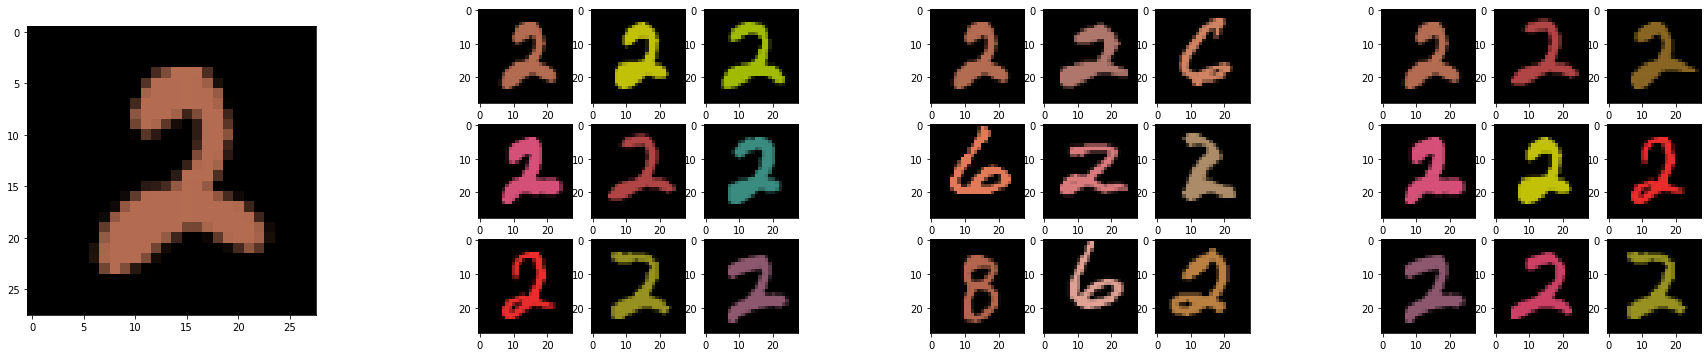

In [14]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()